In [1]:
%reload_ext autoreload
%autoreload 2

In this example, we explore the capabilities of FEINN in solving an soft matrix reinforced with a hard fiber. It is subjected to uniform normal traction under a plane-stress condition.

### General Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Mesh definition

In this case, we load a mesh created using SMESH module from Salome Meca platform.

In [3]:
from mesh_utils import Mesh2D

mesh = Mesh2D.from_salome_med(filepath = './MatrixFiberRVE.med')

Loaded SALOME .med mesh: 817 nodes, 988 elements
Node groups (4): ['left_e', 'right_e', 'top_e', 'bottom_e']
Element groups (7): ['all', 'fiber_s', 'matrix_s', 'bottom_e', 'top_e', 'right_e', 'left_e']


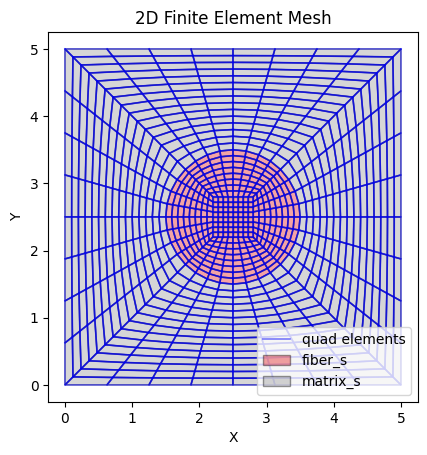

In [4]:
mesh.plot(show_nodes=False, element_groups_to_plot=['fiber_s','matrix_s'])

### Dirichlet boundary conditions

In [5]:
from feinn_solver import BoundaryCondition

bcs = {
        'left_e': [BoundaryCondition(dof=1, value=0.0),
                BoundaryCondition(dof=2, value=0.0)]             
        }

### Define material

In [6]:
from matmodels import LinearElastic

soft = LinearElastic(emod = 1, nu = 0.30)
hard = LinearElastic(emod = 10, nu = 0.30)

matfield = {'matrix_s': soft, 
            'fiber_s': hard}

### von Neumman boundary conditions

In [7]:
from feinn_solver import LineLoad

traction = {
            'right_e': LineLoad(fx = 1.0, fy = 0, reference = "global"),
            }


### Model

In [8]:
from feinn_solver import NFEA

fem_solver = NFEA(mesh = mesh, 
                      bcs = bcs, 
                      matfld = matfield,
                      line_loads = traction,
                      verbose = True
                      )



[matfld] Assigned: ['matrix_s', 'fiber_s']
[matfld] All 988 elements have assigned material
[line_load] Applied 1 line load groups
[BC] Processed 2 Dirichlet condition(s) → 18 total constraint(s)
[BC] Applied Dirichlet BCs → 18 fixed DOFs


In [9]:
fem_solver.run_complete(nsteps=1)

[Load] Set load factor = 1.0000.
Iter   1 | du error: 1.00e+00  Res error: 1.07e-13  Energetic error: 1.00e+00
Iter   2 | du error: 4.29e-14  Res error: 3.06e-14  Energetic error: -1.57e-16
Converged in 2 iterations


In [10]:
fem_solver.udisp

tensor([1.6114, 0.0306, 0.0000,  ..., 0.0112, 1.7175, 0.0114])

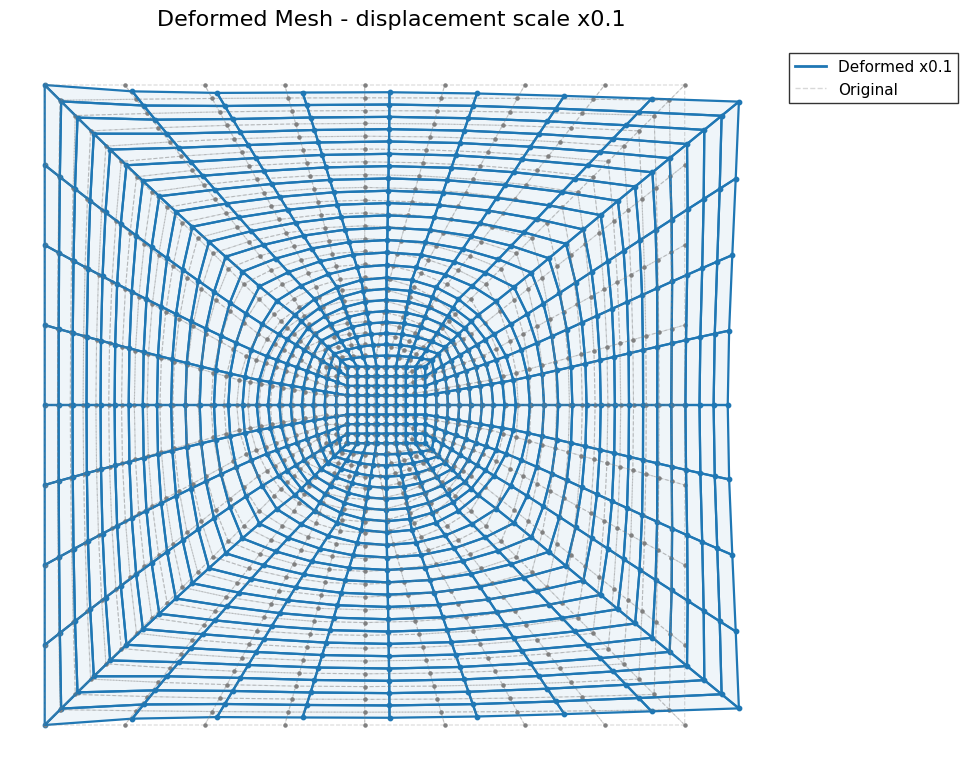

In [11]:
fem_solver.plot_deformed_mesh(scale=0.1)

In [21]:
from feinn_solver import FEINN
from nn_models import mFCNet, FCResNet
import torch.nn as nn

feinn_solver = FEINN(
    mesh=mesh,
    bcs=bcs,
    matfld=matfield,
    line_loads = traction,
    verbose=False,
    nnet = mFCNet(num_layers=3, num_neurons=64),
    bc_weight=1,
    nnet_init = 'xavier',
    )

In [22]:
from types import SimpleNamespace

cfg = SimpleNamespace(**{})

cfg.epochs = 0
cfg.learning_rate = 1e-2
cfg.lr_min = 1e-5

In [23]:
import torch

optimizer = torch.optim.Adam(
    feinn_solver.nnet.parameters(),
    lr = cfg.learning_rate,
    weight_decay = 0,
  )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max = cfg.epochs,
    eta_min = cfg.lr_min
  )

# Entrenar
feinn_solver.train(epochs = cfg.epochs,
                   optimizer=optimizer,
                   scheduler=scheduler,
                   lbfgs_epochs = 50,
                   warmup = True, 
                   verbose = True)

[FEINN] Starting warmup for zero initial displacement
Warmup loss: 3.39e-05
[FEINN] Warmup completado - salida inicial ≈ 0
[FEINN] Zero-output init: max |u| inicial = 3.73e-02

Epoch 1/50 (L-BFGS)
Total Loss: 9.200e-02
  Domain: 8.150e-02
  BC:     1.050e-02

Epoch 10/50 (L-BFGS)
Total Loss: 3.585e-02
  Domain: 3.576e-02
  BC:     8.729e-05

Epoch 20/50 (L-BFGS)
Total Loss: 3.123e-02
  Domain: 3.117e-02
  BC:     6.550e-05

Epoch 30/50 (L-BFGS)
Total Loss: 2.781e-02
  Domain: 2.777e-02
  BC:     3.499e-05

Epoch 40/50 (L-BFGS)
Total Loss: 2.332e-02
  Domain: 2.326e-02
  BC:     5.995e-05

Epoch 50/50 (L-BFGS)
Total Loss: 1.980e-02
  Domain: 1.976e-02
  BC:     4.274e-05
 Maximum gradient (Inf-Norm): 5.18e-02


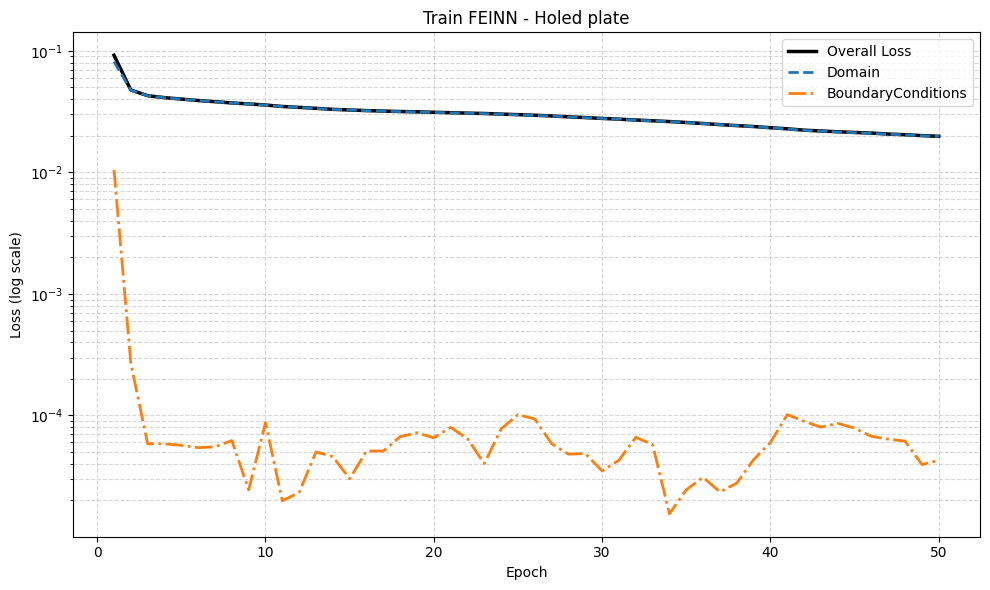

In [24]:
feinn_solver.plot_history(title="Train FEINN - Holed plate")

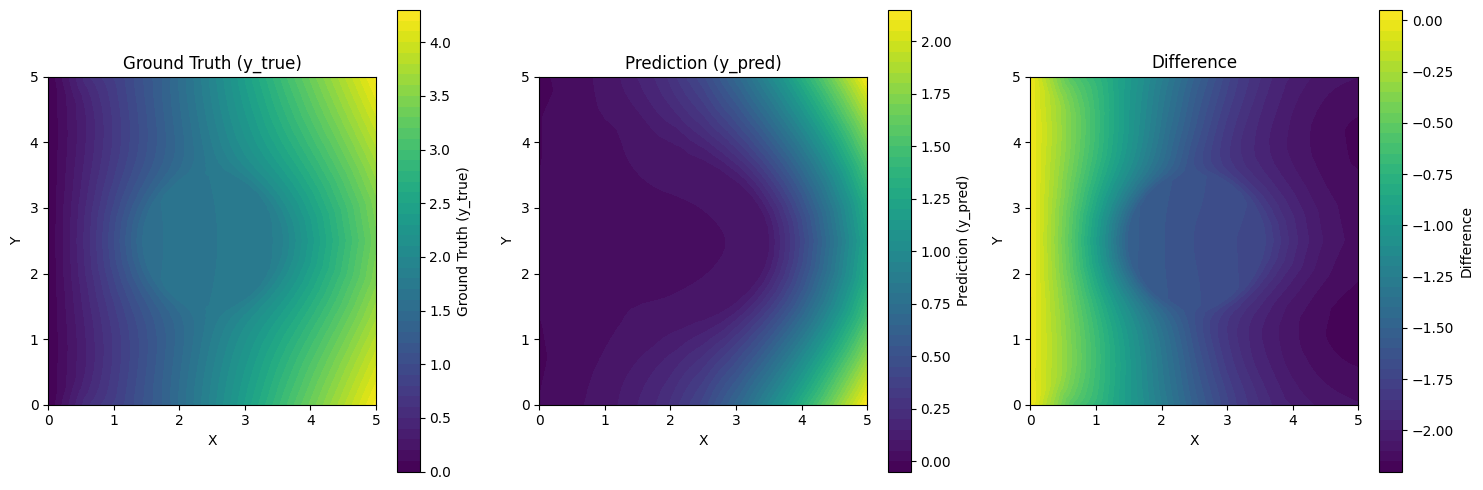

In [25]:
from evaluator import SolutionComparator
comparator = SolutionComparator(mesh, fem_solver.udisp[::2], feinn_solver.udisp[::2])
comparator.plot_comparison(metric='difference')

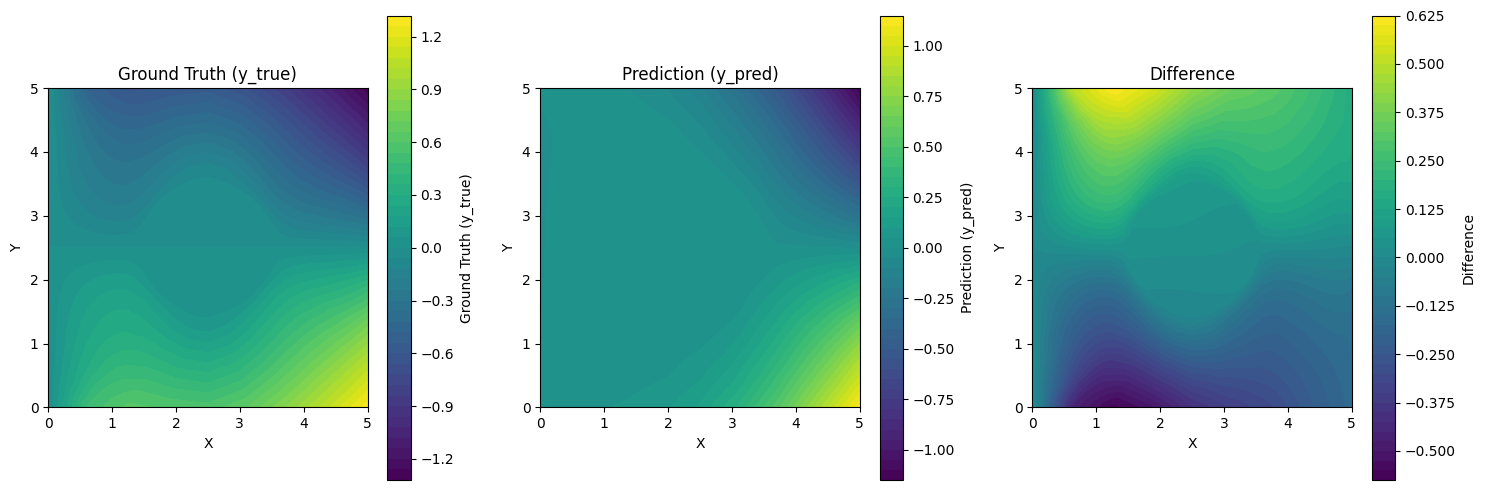

In [26]:
comparator = SolutionComparator(mesh, fem_solver.udisp[1::2], feinn_solver.udisp[1::2])
comparator.plot_comparison(metric='difference')